In [1]:
from datasets import load_dataset

train_dataset = load_dataset('json', data_files='../../Data/Training_Data/WeeveIE_Wikipedia/WeeveLVL4_J.json', split='train')  
eval_dataset = load_dataset('json', data_files='../../Data/Training_Data/WeeveIE_Wikipedia/WeeveLVL3_J.json', split='train')

In [2]:
def formatting_func(example):
    text = f"{example['input']}"
    return text

In [4]:
from transformers import AutoTokenizer

base_model_id = "meta-llama/Llama-2-7b-hf"
tokenizer = AutoTokenizer.from_pretrained(
    base_model_id,
    padding_side="left",
    add_eos_token=True,
    add_bos_token=True,
)
tokenizer.pad_token = tokenizer.eos_token

def generate_and_tokenize_prompt(prompt):
    return tokenizer(formatting_func(prompt))

In [5]:
tokenized_train_dataset = train_dataset.map(generate_and_tokenize_prompt)
tokenized_val_dataset = eval_dataset.map(generate_and_tokenize_prompt)

Let's get a distribution of our dataset lengths, so we can determine the appropriate `max_length` for our input tensors.

389


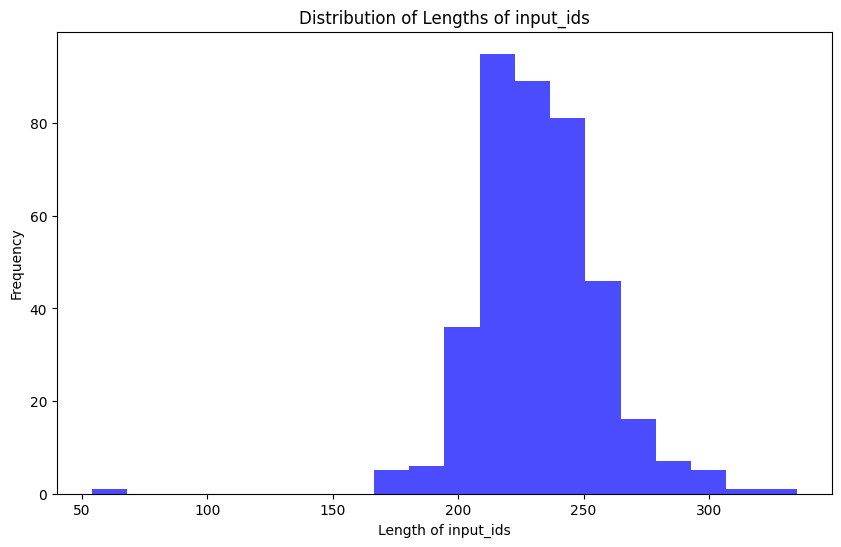

In [6]:
import matplotlib.pyplot as plt

def plot_data_lengths(tokenized_train_dataset, tokenized_val_dataset):
    lengths = [len(x['input_ids']) for x in tokenized_train_dataset]
    lengths += [len(x['input_ids']) for x in tokenized_val_dataset]
    print(len(lengths))

    # Plotting the histogram
    plt.figure(figsize=(10, 6))
    plt.hist(lengths, bins=20, alpha=0.7, color='blue')
    plt.xlabel('Length of input_ids')
    plt.ylabel('Frequency')
    plt.title('Distribution of Lengths of input_ids')
    plt.show()

plot_data_lengths(tokenized_train_dataset, tokenized_val_dataset)

From here, you can choose where you'd like to set the `max_length` to be. You can truncate and pad training examples to fit them to your chosen size. Be aware that choosing a larger `max_length` has its compute tradeoffs. 

I'm using my personal notes to train the model, and they vary greatly in length. I spent some time cleaning the dataset so the samples were about the same length, cutting up individual notes if needed, but being sure to not cut in the middle of a word or sentence.

Now let's tokenize again with padding and truncation, and set up the tokenize function to make labels and input_ids the same. This is basically what [self-supervised fine-tuning is](https://neptune.ai/blog/self-supervised-learning).

In [7]:
max_length = 256 # This was an appropriate max length for my dataset

def generate_and_tokenize_prompt2(prompt):
    result = tokenizer(
        formatting_func(prompt),
        truncation=True,
        max_length=max_length,
        padding="max_length",
    )
    result["labels"] = result["input_ids"].copy()
    return result

In [8]:
tokenized_train_dataset = train_dataset.map(generate_and_tokenize_prompt2)
tokenized_val_dataset = eval_dataset.map(generate_and_tokenize_prompt2)

Map:   0%|          | 0/212 [00:00<?, ? examples/s]

Map:   0%|          | 0/177 [00:00<?, ? examples/s]

Check that `input_ids` is padded on the left with the `eos_token` (2) and there is an `eos_token` 2 added to the end, and the prompt starts with a `bos_token` (1).

In [9]:
print(tokenized_train_dataset[1]['input_ids'])

[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 29871, 278, 16547, 540, 12355, 267, 694, 341, 1008, 347, 988, 2686, 338, 29892, 763, 278, 11751, 4671, 2496, 7226, 29906, 29946, 29962, 13, 13, 28173, 5007, 278, 29382, 29892, 12931, 19952, 29892, 376, 4178, 393, 5347, 29892, 306, 3282, 29915, 29873, 8709, 1532, 23382, 363, 592, 262, 2186, 429, 2232, 472, 12855, 29889, 1932, 306, 28996, 5377, 304, 6505, 278, 379, 6727, 295, 29892, 306, 1033, 1074, 278, 11751, 4671, 2496, 29889, 306, 4689, 5007, 278, 29382, 1156, 1641, 367, 29872, 513, 10857, 29873, 491, 278, 2114, 393, 14259, 679, 304, 1074, 278, 263, 2475, 1608, 8879, 14761, 373, 1425, 311, 10819, 526, 269, 1428, 1646, 29889, 313, 17245, 29892, 29897, 372, 471, 15761, 11280, 278, 1394, 291, 29915, 29879, 350, 2152, 15741, 278, 11751, 4671, 2496, 1213, 29961, 29906, 29945, 29962, 940, 2715, 393, 376, 3664, 5595, 3721, 363, 5917, 911, 470, 5360, 29892, 306, 22151, 9442, 278, 29382, 7415, 263, 5305, 363, 1906, 1058, 526, 12534, 26902, 411, 413, 

Now all the samples should be the same length, `max_length`.

389


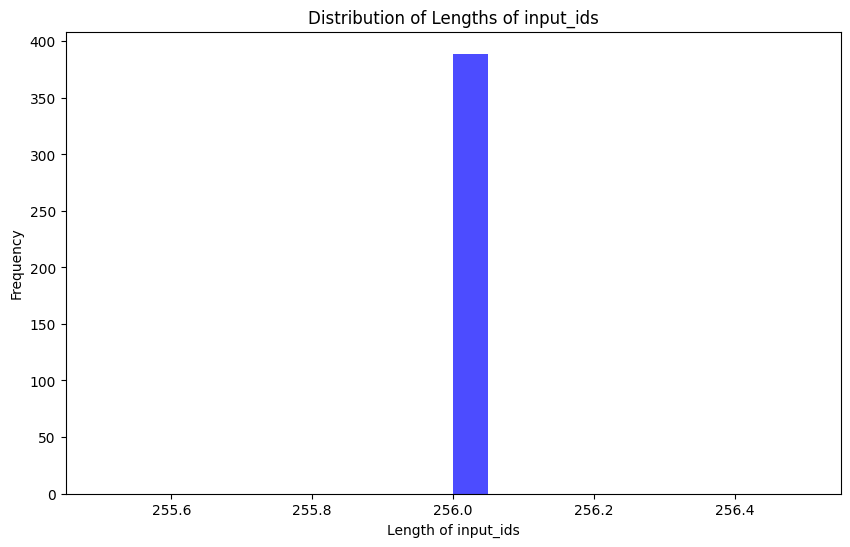

In [10]:
plot_data_lengths(tokenized_train_dataset, tokenized_val_dataset)